# Red Neuronal Siamesa para Verificación de Similitud entre Clases de Fallos Presentes en Turbinas de Tipo Jacket
El propósito de este notebook es crear la Red Neuronal Siamesa (SNN) que se va a encargar de verificar el nivel de similitud que existe entre un datos ingresado al modelo y los errores existentes, los cuales en este caso son de fisura y perno flojo.

La arquitectura general de una red convolucional es la siguiente:

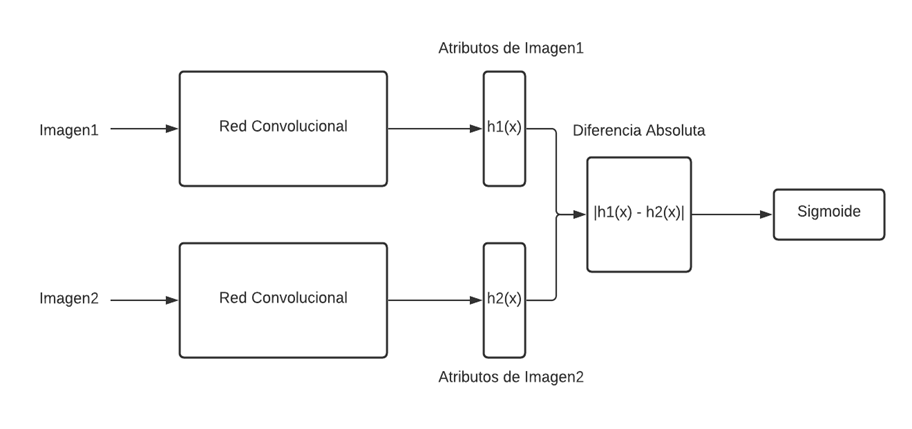

Una SNN básicamente utiliza 2 redes convolucionales exactamente iguales (es decir que poseen los mismos pesos), en donde se ingresa una imagen la entrada de cada red neuronal. Luego, cada una de las CNNs obtiene un vector que representa las características principales de la imagen ingresada a dicha red para posteriormente obtener la diferencia absoluta entre este par de vectores (se comparan cada uno de los valores de un vector con los del otro vector). Finalmente, el valor resultante de la comparación entre los vectores ingresa a una función sigmoide, la cual determina el nivel de similitud existente entre las imágenes que fueron ingresadas al modelo. Usualmente, se considera que valores mayores a 0.5 correspoden a una similitud existente, mientras que valores menores a 0.5 corresponden a una similitud inexistente.


## Importaciones
Realizamos las importaciones necesarias para llevar a cabo la obtención de datos, el procesamiento de datos y la creación de la red neuronal siamesa.

In [1]:
from google.colab import drive
from os import listdir
from os.path import isfile, join
from scipy.io import loadmat
from random import randint
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import random

import os

## Obtención de Datos
Se obtienen los conjuntos de datos relacionados a fisura y perno flojo, todos los experimentos y todos los niveles de white noise.

In [2]:
# Establecemos conexión con Google Drive para acceder a la carpeta de datasets
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Guardamos la dirección de los datasets (experimentos) en una variable para utilizala posteriormente
dataset_datos_dir = 'drive/MyDrive/DATOS_EXPERIMENTALES_JACKET/DATOS'

In [4]:
# Obtenemos una lista con todos los nombres de los archivos relacionados a los experimentos realizados
dataset_datos_files = [dataset_datos_dir+'/'+filename for filename in listdir(dataset_datos_dir) if isfile(join(dataset_datos_dir, filename))]

In [5]:
# Creamos listas en donde se almacenarán los archivos relacionados a experimentos de fisura y experimentos de perno flojo respectivamente
datos_fisura = []
datos_pernoflojo = []

In [6]:
# Iteramos los nombres de todos los archivos en la lista general previamente creada
for filename in listdir(dataset_datos_dir):
  # Obtenemos el nombre del archivo tal cual, sin direcciones previas
  if isfile(join(dataset_datos_dir, filename)):
    nombre_archivo = filename.split('.')[0]
    # El estado de fisura se asocia al número 3 en los nombres de los archivos, si cumple la condición el archivo, guardamos en la lista datos_fisura
    if (nombre_archivo.split('_')[0] == '3'):
      datos_fisura.append(dataset_datos_dir + '/' + filename)
    # El estado de fisura se asocia al número 4 en los nombres de los archivos, si cumple la condición el archivo, guardamos en la lista datos_pernoflojo
    elif (nombre_archivo.split('_')[0] == '4'):
      datos_pernoflojo.append(dataset_datos_dir + '/' + filename)

### Datos Fisura
Anteriormente se creó una lista con los nombres de los archivos, pero no tenemos un conjunto de archivos con datos en el formato deseado, por lo que en esta sección se va a realizar dicho trabajo. Además, se pretende agregar columnas asociadas con el número de experimento y el nivel de white noise para no mezclar los datos al momento de realizar las imágenes.

In [7]:
# Se crean 2 listas, una asociada al número de experimento y otra asociada al nivel de white noise presente durante el experimento 
numero_experimentos_fisura = []
amplitud_experimentos_fisura = []

In [8]:
# Iteramos los nombres de los archivos dentro del conjunto que contiene los datos de fisura
for nombre_archivo in datos_fisura:
  # Obtenemos el nombre del experimento
  nombre_experimento = nombre_archivo.split('/')[4]
  # Obtenemos el número del experimento
  numero_experimento = nombre_experimento.split('_')[1]
  # Obtenemos el nivel de white noise del experimento
  amplitud_experimento = nombre_experimento.split('.')[0].split('_')[2].replace('A', '')
  # Agregamos el número del experimento a la lista numero_experimentos_fisura creada anteriormente
  numero_experimentos_fisura.append(int(numero_experimento))
  # Agregamos el nivel de white noise del experimento a la lista amplitud_experimentos_fisura creada anteriormente
  if amplitud_experimento == '05':
    amplitud_experimento = 0.5
    amplitud_experimentos_fisura.append(amplitud_experimento)
  else:
    amplitud_experimentos_fisura.append(int(amplitud_experimento))

In [9]:
# Creamos un DataFrame vacío
df_fisura = pd.DataFrame()

In [10]:
# Iteramos por rango la lista datos_fisura
for indice in range(len(datos_fisura)):
  # Obtenemos la dirección dentro de la iteración correspondiente
  direccion = datos_fisura[indice]
  # Transformamos el .mat a un formato en el que se pueda transformar a DataFrame
  mat = loadmat(direccion)
  df = pd.DataFrame(mat['data'])
  # Para todos los valores del experimento, creamos columnas en donde sus valores se asocian con el nivel de wn y el # de experimento
  df['#_exp'] = numero_experimentos_fisura[indice]
  df['amplitud'] = amplitud_experimentos_fisura[indice]
  # Colocamos al final del DataFrame df_fisura creado el nuevo DataFrame 
  df_fisura = pd.concat([df_fisura, df], axis = 0)

In [11]:
# Revisamos el conjunto de datos obtenido para fisura
df_fisura.head(8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,#_exp,amplitud
0,0.000132,0.000185,0.000122,0.000105,0.000141,0.000075,0.000007,0.000231,0.000299,0.000113,0.000228,0.000225,0.000168,0.000018,0.000344,0.000275,-0.000017,0.000046,0.000200,0.000169,0.000097,0.000196,-0.000053,0.000018,1,1.0
1,0.000092,0.000223,0.000166,0.000127,0.000191,0.000137,0.000075,0.000192,0.000240,0.000095,0.000279,0.000231,0.000145,0.000037,0.000339,0.000092,0.000085,0.000074,0.000128,0.000163,0.000074,0.000085,0.000063,-0.000027,1,1.0
2,0.000091,0.000280,0.000188,0.000130,0.000172,0.000102,0.000161,0.000158,0.000211,0.000123,0.000269,0.000206,0.000198,0.000041,0.000312,0.000179,0.000011,0.000079,0.000117,0.000146,0.000085,0.000089,-0.000014,0.000020,1,1.0
3,0.000179,0.000199,0.000249,0.000102,0.000268,0.000140,0.000126,0.000231,0.000239,0.000102,0.000284,0.000175,0.000164,0.000082,0.000311,0.000235,0.000031,0.000079,0.000257,0.000110,0.000050,0.000120,0.000080,0.000057,1,1.0
4,0.000282,0.000277,0.000202,0.000211,0.000251,0.000159,0.000096,0.000205,0.000342,0.000113,0.000240,0.000272,0.000214,0.000057,0.000304,0.000302,0.000047,0.000150,0.000271,0.000168,0.000126,0.000224,0.000105,0.000058,1,1.0
5,0.000005,0.000196,0.000247,0.000109,0.000186,0.000115,0.000042,0.000129,0.000255,0.000108,0.000315,0.000214,0.000237,-0.000001,0.000334,0.000202,-0.000008,0.000081,0.000173,0.000165,0.000126,0.000107,-0.000012,0.000006,1,1.0
6,0.000176,0.000372,0.000223,0.000154,0.000258,0.000165,0.000170,0.000157,0.000228,0.000126,0.000282,0.000219,0.000198,0.000081,0.000333,0.000146,0.000065,0.000070,0.000140,0.000145,0.000099,0.000115,0.000068,-0.000031,1,1.0
7,0.000133,0.000171,0.000187,0.000182,0.000237,0.000159,0.000121,0.000280,0.000293,0.000096,0.000248,0.000202,0.000160,0.000015,0.000319,0.000335,-0.000004,0.000102,0.000201,0.000193,0.000180,0.000171,-0.000009,0.000095,1,1.0


In [12]:
# Si dividimos para 99097 el df_fisura deberíamos obtener 20 experimentos en total
len(df_fisura)/99097

20.0

#### Procesamiento de Datos
En esta sección, nos enfocaremos en obtener las imágenes mencionadas en la introducción del notebook y verificar si las imágenes se generaron correctamente. Debemos tener en cuenta que sólo es posible generar 64 imágenes por experimento individual debido a la longitud de las columnas, y que sólo se tienen 20 experimentos por dataset (ya sea fisura o perno flojo).

Cuando nos vayamos a referir a imágenes, estaremos hablando de imágenes 16x16 o de imágenes 24x16x16 (se va a especificar cuál de las dos en los comentarios).

In [13]:
# Establecemos 2 listas, una con los posibles experimentos y otra con los posibles niveles de white noise, lo cual nos ayudará a segmentar los datos
experimentos = [1, 2, 3, 4, 5]
wns = [0.5, 1, 2, 3]
# Creamos una lista en donde pondremos todas las imágenes creadas, segmentadas por experimento y white noise
arreglo_imagenes_por_experimento_fisura = []

# Iteramos por experimento y por nivel de white noise
for i in experimentos:
  for j in wns:
    # Creamos filtros que nos permiten identificar el experimento por su número asociado y por su nivel de white noise dentro del conjunto de datos
    filter1 = df_fisura["#_exp"] == i
    filter2 = df_fisura["amplitud"] == j
    # Filtramos y deshacemos las filas que no corresponden a la búsqueda
    dataset_experimento = df_fisura.where(filter1 & filter2).dropna()
    # Creamos arreglo en donde almacenaremos listas de imágenes asociadas a cada columna en un experimento individual
    arreglo_matrices_asociadas = []

    # En el conjunto filtrado, iteramos por cada columna (de la columna 0 a la 23)
    for n in range(24):
      # Establecemos un límite inferior y un límite superior
      indice_inicio = 0
      indice_fin = 256
      # Del conjunto filtrado, obtenemos un subconjunto con muestras cada 6 pasos
      columna_cada_6 = dataset_experimento[n][::6]
      # Creamos una lista en donde guardaremos todas las imágenes creadas dentro de la columna en la que se esta iterando
      matrices_columna = []
    
      # Recorremos en valores de 256 la columna del subconjunto creado para generar las imágenes 16x16 correspondientes 
      while indice_fin < len(columna_cada_6):
        # Guardamos el conjunto de 256 datos dentro de un arreglo
        vector = columna_cada_6[indice_inicio:indice_fin]
        # Redimensionamos el arreglo (de 1x256 a 16x16)
        matriz = vector.to_numpy().reshape((16, 16))
        # Agregamos la imagen dentro de la lista matrices_columna
        matrices_columna.append(matriz)
        # Establecemos el nuevo límite inferior y superior en donde se encontrarán los datos de mi nueva imagen 16x16
        indice_inicio = indice_fin
        indice_fin = indice_fin + 256
      
      # Agregamos las listas de imágenes 16x16 asociadas a una columna a arreglo_matrices_asociadas
      arreglo_matrices_asociadas.append(matrices_columna)
    
    # Agregamos arreglo_matrices_asociadas a arreglos_imagenes_por_experimento, en donde tenemos listas de listas asociadas a un experimento individual
    arreglo_imagenes_por_experimento_fisura.append(arreglo_matrices_asociadas)

In [14]:
len(arreglo_imagenes_por_experimento_fisura)

20

In [15]:
len(arreglo_imagenes_por_experimento_fisura[0])

24

In [16]:
len(arreglo_imagenes_por_experimento_fisura[0][0])

64

In [17]:
arreglo_imagenes_por_experimento_fisura[0][0][0].size

256

In [18]:
arreglo_imagenes_por_experimento_fisura[0][0][0].shape

(16, 16)

In [19]:
# Creamos un arreglos general para todas las imágenes de dimensionamiento (24, 16, 16)
arreglo_imagenes_fisura = []

# Iteramos cada experimento en la lista de experimentos creada previamente
for experimento in arreglo_imagenes_por_experimento_fisura:
  # Iteramos en un rango de 64 para usarlo posteriormente
  for idx in range(64):
    # Para cada iteración se crea el arreglo en donde se agregaran las capas correctas de la imagen de dimensionamniento (24, 16, 16)
    imagen = []
    # Iteramos para cada fila en el experimento (son 24 filas)
    for fila in experimento:
      # Asociamos por índice los valores de cada lista de imágenes para establecer la relación correcta y agregamos al arreglo creado
      capa_imagen = fila[idx]
      imagen.append(capa_imagen)

    # Transformamos la lista de 24 capas a un arreglo numérico
    arreglo_imagenes_fisura.append(np.array(imagen))

In [20]:
# Revisamos el número de imágenes creadas
len(arreglo_imagenes_fisura)

1280

In [21]:
# Revisamos el dimensionamiento y tipo de un elemento aleatorio en la lista de imágenes
indice_imagen_fisura = randint(0, len(arreglo_imagenes_fisura) - 1)
arreglo_imagenes_fisura[indice_imagen_fisura].shape, type(arreglo_imagenes_fisura[0]), indice_imagen_fisura

((24, 16, 16), numpy.ndarray, 804)

### Datos Perno Flojo
Anteriormente se creó una lista con los nombres de los archivos, pero no tenemos un conjunto de archivos con datos en el formato deseado, por lo que en esta sección se va a realizar dicho trabajo. Además, se pretende agregar columnas asociadas con el número de experimento y el nivel de white noise para no mezclar los datos al momento de realizar las imágenes.

In [22]:
# Se crean 2 listas, una asociada al número de experimento y otra asociada al nivel de white noise presente durante el experimento 
numero_experimentos_pernoflojo = []
amplitud_experimentos_pernoflojo = []

In [23]:
# Iteramos los nombres de los archivos dentro del conjunto que contiene los datos de fisura
for nombre_archivo in datos_pernoflojo:
  # Obtenemos el nombre del experimento
  nombre_experimento = nombre_archivo.split('/')[4]
  # Obtenemos el número del experimento
  numero_experimento = nombre_experimento.split('_')[1]
  # Obtenemos el nivel de white noise del experimento
  amplitud_experimento = nombre_experimento.split('.')[0].split('_')[2].replace('A', '')
  # Agregamos el número del experimento a la lista numero_experimentos_pernoflojo creada anteriormente
  numero_experimentos_pernoflojo.append(int(numero_experimento))
  # Agregamos el nivel de white noise del experimento a la lista amplitud_experimentos_pernoflojo creada anteriormente
  if amplitud_experimento == '05':
    amplitud_experimento = 0.5
    amplitud_experimentos_pernoflojo.append(amplitud_experimento)
  else:
    amplitud_experimentos_pernoflojo.append(int(amplitud_experimento))

In [24]:
# Creamos un DataFrame vacío
df_pernoflojo = pd.DataFrame()

In [25]:
# Iteramos por rango la lista datos_fisura
for indice in range(len(datos_pernoflojo)):
  # Obtenemos la dirección dentro de la iteración correspondiente
  direccion = datos_pernoflojo[indice]
  # Transformamos el .mat a un formato en el que se pueda transformar a DataFrame
  mat = loadmat(direccion)
  df = pd.DataFrame(mat['data'])
  # Para todos los valores del experimento, creamos columnas en donde sus valores se asocian con el nivel de wn y el # de experimento
  df['#_exp'] = numero_experimentos_pernoflojo[indice]
  df['amplitud'] = amplitud_experimentos_pernoflojo[indice]
  # Colocamos al final del DataFrame df_fisura creado el nuevo DataFrame 
  df_pernoflojo = pd.concat([df_pernoflojo, df], axis = 0)

In [26]:
# Revisamos el conjunto de datos obtenido para pernoflojo
df_pernoflojo.head(8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,#_exp,amplitud
0,0.000168,0.000204,0.000213,0.000135,0.000201,0.000099,0.000108,0.000189,0.000212,0.000093,0.000257,0.000196,0.000173,0.000029,0.000316,0.000202,0.000010,0.000085,0.000151,0.000136,0.000116,0.000099,0.000054,0.000111,1,0.5
1,0.000122,0.000277,0.000213,0.000180,0.000230,0.000172,0.000068,0.000213,0.000214,0.000095,0.000272,0.000172,0.000173,0.000050,0.000292,0.000178,0.000021,0.000022,0.000203,0.000139,0.000076,0.000164,0.000089,0.000076,1,0.5
2,0.000099,0.000214,0.000128,0.000153,0.000217,0.000100,0.000064,0.000174,0.000225,0.000116,0.000245,0.000202,0.000140,0.000012,0.000309,0.000256,0.000023,0.000089,0.000225,0.000162,0.000098,0.000154,0.000091,0.000092,1,0.5
3,0.000150,0.000258,0.000209,0.000163,0.000213,0.000120,0.000066,0.000157,0.000220,0.000096,0.000229,0.000203,0.000157,0.000057,0.000292,0.000260,0.000062,0.000077,0.000212,0.000178,0.000123,0.000150,0.000056,0.000130,1,0.5
4,0.000194,0.000244,0.000194,0.000201,0.000202,0.000127,0.000133,0.000197,0.000212,0.000110,0.000266,0.000199,0.000181,0.000040,0.000336,0.000209,0.000092,0.000097,0.000183,0.000170,0.000114,0.000127,0.000064,0.000087,1,0.5
5,0.000156,0.000287,0.000188,0.000119,0.000234,0.000127,0.000102,0.000198,0.000216,0.000097,0.000280,0.000222,0.000140,0.000058,0.000296,0.000212,0.000061,0.000097,0.000231,0.000156,0.000090,0.000155,0.000076,0.000091,1,0.5
6,0.000150,0.000230,0.000198,0.000239,0.000247,0.000150,0.000052,0.000178,0.000255,0.000115,0.000235,0.000189,0.000216,0.000072,0.000299,0.000233,0.000060,0.000124,0.000225,0.000157,0.000133,0.000153,0.000060,0.000087,1,0.5
7,0.000130,0.000230,0.000207,0.000116,0.000212,0.000108,0.000096,0.000178,0.000200,0.000130,0.000260,0.000203,0.000216,0.000057,0.000329,0.000261,0.000031,0.000045,0.000236,0.000178,0.000081,0.000160,0.000079,0.000115,1,0.5


In [27]:
# Si dividimos para 99097 el df_pernoflojo deberíamos obtener 20 experimentos en total
len(df_pernoflojo)/99097

20.0

#### Procesamiento de Datos
En esta sección, nos enfocaremos en obtener las imágenes mencionadas en la introducción del notebook y verificar si las imágenes se generaron correctamente. Debemos tener en cuenta que sólo es posible generar 64 imágenes por experimento individual debido a la longitud de las columnas, y que sólo se tienen 20 experimentos por dataset (ya sea fisura o perno flojo).

Cuando nos vayamos a referir a imágenes, estaremos hablando de imágenes 16x16 o de imágenes 24x16x16 (se va a especificar cuál de las dos en los comentarios).

In [28]:
# Establecemos 2 listas, una con los posibles experimentos y otra con los posibles niveles de white noise, lo cual nos ayudará a segmentar los datos
experimentos = [1, 2, 3, 4, 5]
wns = [0.5, 1, 2, 3]
# Creamos una lista en donde pondremos todas las imágenes creadas, segmentadas por experimento y white noise
arreglo_imagenes_por_experimento_pernoflojo = []

# Iteramos por experimento y por nivel de white noise
for i in experimentos:
  for j in wns:
    # Creamos filtros que nos permiten identificar el experimento por su número asociado y por su nivel de white noise dentro del conjunto de datos
    filter1 = df_pernoflojo["#_exp"] == i
    filter2 = df_pernoflojo["amplitud"] == j
    # Filtramos y deshacemos las filas que no corresponden a la búsqueda
    dataset_experimento = df_pernoflojo.where(filter1 & filter2).dropna()
    # Creamos arreglo en donde almacenaremos listas de imágenes asociadas a cada columna en un experimento individual
    arreglo_matrices_asociadas = []

    # En el conjunto filtrado, iteramos por cada columna (de la columna 0 a la 23)
    for n in range(24):
      # Establecemos un límite inferior y un límite superior
      indice_inicio = 0
      indice_fin = 256
      # Del conjunto filtrado, obtenemos un subconjunto con muestras cada 6 pasos
      columna_cada_6 = dataset_experimento[n][::6]
      # Creamos una lista en donde guardaremos todas las imágenes creadas dentro de la columna en la que se esta iterando
      matrices_columna = []
    
      # Recorremos en valores de 256 la columna del subconjunto creado para generar las imágenes 16x16 correspondientes 
      while indice_fin < len(columna_cada_6):
        # Guardamos el conjunto de 256 datos dentro de un arreglo
        vector = columna_cada_6[indice_inicio:indice_fin]
        # Redimensionamos el arreglo (de 1x256 a 16x16)
        matriz = vector.to_numpy().reshape((16, 16))
        # Agregamos la imagen dentro de la lista matrices_columna
        matrices_columna.append(matriz)
        # Establecemos el nuevo límite inferior y superior en donde se encontrarán los datos de mi nueva imagen 16x16
        indice_inicio = indice_fin
        indice_fin = indice_fin + 256
      
      # Agregamos las listas de imágenes 16x16 asociadas a una columna a arreglo_matrices_asociadas
      arreglo_matrices_asociadas.append(matrices_columna)
    
    # Agregamos arreglo_matrices_asociadas a arreglos_imagenes_por_experimento, en donde tenemos listas de listas asociadas a un experimento individual
    arreglo_imagenes_por_experimento_pernoflojo.append(arreglo_matrices_asociadas)

In [29]:
len(arreglo_imagenes_por_experimento_pernoflojo)

20

In [30]:
len(arreglo_imagenes_por_experimento_pernoflojo[0])

24

In [31]:
len(arreglo_imagenes_por_experimento_pernoflojo[0][0])

64

In [32]:
arreglo_imagenes_por_experimento_pernoflojo[0][0][0].size

256

In [33]:
arreglo_imagenes_por_experimento_pernoflojo[0][0][0].shape

(16, 16)

In [34]:
# Creamos un arreglos general para todas las imágenes de dimensionamiento (24, 16, 16)
arreglo_imagenes_pernoflojo = []

# Iteramos cada experimento en la lista de experimentos creada previamente
for experimento_i in arreglo_imagenes_por_experimento_pernoflojo:
  # Iteramos en un rango de 64 para usarlo posteriormente
  for idx in range(64):
    # Para cada iteración se crea el arreglo en donde se agregaran las capas correctas de la imagen de dimensionamniento (24, 16, 16)
    imagen = []
    # Iteramos para cada fila en el experimento (son 24 filas)
    for fila in experimento_i:
      # Asociamos por índice los valores de cada lista de imágenes para establecer la relación correcta y agregamos al arreglo creado
      capa_imagen = fila[idx]
      imagen.append(capa_imagen)

    # Transformamos la lista de 24 capas a un arreglo numérico
    arreglo_imagenes_pernoflojo.append(np.array(imagen))

In [35]:
# Revisamos el número de imágenes creadas
len(arreglo_imagenes_pernoflojo)

1280

In [36]:
# Revisamos el dimensionamiento y tipo de un elemento aleatorio en la lista de imágenes
indice_imagen_pernoflojo = randint(0, len(arreglo_imagenes_pernoflojo) - 1)
arreglo_imagenes_pernoflojo[indice_imagen_pernoflojo].shape, type(arreglo_imagenes_pernoflojo[0]), indice_imagen_pernoflojo

((24, 16, 16), numpy.ndarray, 653)

## Red Neuronal Siamesa
En esta sección se van a construir los pares positivos y negativos que van a ser utilizados para el entrenamiento de la red neuronal siamesa. Posterior a eso, se procederá con la experimentación de distintas arquitecturas de las CNN involucradas en la SNN para así escoger los mejores parámetros de entrenamiento.

Tenemos los siguientes arreglos que contienen 1280 imágenes asociadas al tipo de fallo que representan:

- arreglo_imagenes_fisura
- arreglo_imagenes_pernoflojo

#### Creación de Pares de Entrenamiento
Se crean pares de imágenes positivos y negativos (pertenecen al mismo fallo y no pertenecen al mismo fallo) a partir de los conjuntos de datos previamente mencionados.

In [37]:
def crear_pares(arreglo_imagenes_fisura, arreglo_imagenes_pernoflojo):
  """
  Función empleada para crear los pares de imágenes que se utilizan
  para el entrenamiento de la SNN.
  """
  print("Creando pares...")
  # Creamos arreglo en donde se insertarán los pares (positivos y negativos)
  pares_img = []
  # Creamos arreglo en donde se insertarán la clasificación de los pares (similares = 1, no similares = 0)
  pares_label = []

  # Recorremos el arreglo de imágenes de fisura y por cada imagen recorrida creamos un par positivo y uno negativo
  for imagen_fisura in arreglo_imagenes_fisura:

    # La imagen positiva será un dato aleatorio perteneciente al arreglo de la misma clase (fisura)
    imagen_positiva_fisura = random.choice(arreglo_imagenes_fisura)
    # La imagen negativa será un dato aleatorio perteneciente al arreglo de la otra clase (perno flojo)
    imagen_negativa_fisura = random.choice(arreglo_imagenes_pernoflojo)

    # Agregamos el par de imagenes positivas al arreglo de pares de imagenes
    pares_img.append([imagen_fisura, imagen_positiva_fisura])
    # Agregamos el label correspondiente a un par de imágenes positivas (1)
    pares_label.append([1])

    # Agregamos el par de imagenes negativas al arreglo de pares de imagenes
    pares_img.append([imagen_fisura, imagen_negativa_fisura])
    # Agregamos el label correspondiente a un par de imágenes negativas (0)
    pares_label.append([0])

  # Recorremos el arreglo de imágenes de fisura y por cada imagen recorrida creamos un par positivo y uno negativo
  for imagen_pernoflojo in arreglo_imagenes_pernoflojo:

    # La imagen positiva será un dato aleatorio perteneciente al arreglo de la misma clase (perno flojo)
    imagen_positiva_pernoflojo = random.choice(arreglo_imagenes_pernoflojo)
    # La imagen negativa será un dato aleatorio perteneciente al arreglo de la otra clase (fisura)
    imagen_negativa_pernoflojo = random.choice(arreglo_imagenes_fisura)

    # Agregamos el par de imagenes positivas al arreglo de pares de imagenes
    pares_img.append([imagen_pernoflojo, imagen_positiva_pernoflojo])
    # Agregamos el label correspondiente a un par de imágenes positivas (1)
    pares_label.append([1])

    # Agregamos el par de imagenes negativas al arreglo de pares de imagenes
    pares_img.append([imagen_pernoflojo, imagen_negativa_pernoflojo])
    # Agregamos el label correspondiente a un par de imágenes negativas (0)
    pares_label.append([0])
  
  print("Pares creados.")

  return (np.array(pares_img), np.array(pares_label))

In [38]:
(pares, labels) = crear_pares(arreglo_imagenes_fisura, arreglo_imagenes_pernoflojo)

Creando pares...
Pares creados.


In [39]:
# Verificamos que la cantidad de pares y la cantidad de labels sean la misma
len(pares), len(labels)

(5120, 5120)

#### Segmentación de Conjunto de Entrenamiento y Conjunto de Prueba
Se van a dividir los arreglos de pares de imágenes y labels en dos segmentos: uno relacionado a los que se van a utilizar para el entrenamiento de la red neuronal siamesa, y otro asociado con la calificación de precisión del entrenamiento dado.

Para realizar esto destinamos el 20% de pares y labels al conjunto de prueba, mientras que el 80% restante al conjunto de entrenamiento. Sin embargo, primero debemos aleatorizar el conjunto general de pares y labels.

In [40]:
# Aleatorizamos los pares y los labels sin perder las relaciones entre los valores de ambos arreglos
pares_aleatorizados, labels_aleatorizados = shuffle(pares, labels)

In [41]:
# Obtenemos el 80% de los valores totales
porcentaje_80 = int(len(pares_aleatorizados)*0.8)
porcentaje_80

4096

In [42]:
# Definimos el conjunto de entrenamiento
pares_entrenamiento = pares_aleatorizados[:porcentaje_80]
labels_entrenamiento = labels_aleatorizados[:porcentaje_80]

# Definimos el conjunto de prueba
pares_prueba = pares_aleatorizados[porcentaje_80:]
labels_prueba = labels_aleatorizados[porcentaje_80:]

In [43]:
# Verificamos segmentación
len(pares_entrenamiento), len(labels_entrenamiento), len(pares_prueba), len(labels_prueba)

(4096, 4096, 1024, 1024)

#### Creación de la SNN
En esta sección se creará la arquitectura base de la SNN a la que posteriormente se le puede realizar configuraciones dependiendo de los resultados obtenidos de los experimentos posteriores.

Procedemos a establecer la función que obtendrá la distancia euclidiana entre los vectores resultantes de las CNNs.

In [44]:
def euclidean_distance(vectors):
  
  # Descomprimimos los vectores en listas separadas
  (featsA, featsB) = vectors

  # Realizamos la suma de las diferenias cuadradas entre vectores
  sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)

  # Retornamos la distancia euclidiana
  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

#### Creación de las CNNs
Establecemos la estructura interna de las redes neuronales convolucionales que se localizan dentro de la red neuronal siamesa.

In [45]:
# Inicializamos la semilla aleatoria para reproducibilidad de valores
tf.random.set_seed(42)

Modelo Experimental #1

In [46]:
# Creamos función que retorna la estructura de la red convolucional que se va a utilizar
def build_siamese_model_1(input_shape):
  model = tf.keras.Sequential([
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=2,
                                                        activation='relu',
                                                        padding='same',
                                                        input_shape=input_shape),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=2,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.GlobalAveragePooling2D(),
                                tf.keras.layers.Dense(64)
  ])

  return model

#### Creación del modelo general (SNN) y Entrenamiento 

In [47]:
# Creamos el modelo general
IMG_SHAPE = (24, 16, 16)

# Definimos los inputs (imágenes) que ingresan a cada CNN
imgA = tf.keras.Input(IMG_SHAPE)
imgB = tf.keras.Input(IMG_SHAPE)

# Creamos el featureExtractor, el cual obtiene las características principales de las imágenes ingresadas y las muestra en un vector
featureExtractor = build_siamese_model_1(input_shape=IMG_SHAPE)

# Ingresamos cada imagen al featureExtractor
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# Creamos una capa Lambda (que aplica una función sobre los datos) para obtener la distancia euclidiana
distancia = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

# Creamos la última capa asociada a la función de activación sigmoide
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(distancia)

# Establecemos el modelo general
model_1 = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

# Empleamos el loss como binary_crossentropy porque solo queremos saber si las imágenes son similares o no (no queremos clasificarlas)
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Hacemos el fit del modelo
history_1 = model_1.fit(
    [pares_entrenamiento[:, 0], pares_entrenamiento[:, 1]], labels_entrenamiento[:],
     validation_data=([pares_prueba[:, 0], pares_prueba[:, 1]], labels_prueba[:]),
     batch_size=32,
     epochs=5
)

Epoch 1/5
128/128 [==============================] - 8s 58ms/step - loss: 0.6932 - accuracy: 0.4861 - val_loss: 0.6932 - val_accuracy: 0.4893
Epoch 2/5
128/128 [==============================] - 7s 56ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4893
Epoch 3/5
128/128 [==============================] - 7s 56ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4893
Epoch 4/5
128/128 [==============================] - 7s 57ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4893
Epoch 5/5
128/128 [==============================] - 7s 57ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4893


#### Visualización de Curva de Pérdidas
Crearemos una función que se utilizará para visualizar cómo se comportan las pérdidas por cada iteración en un experimento expecífico.

In [48]:
def graficar_curva_perdidas(history):
  """
  Función utilizada para visualizar la historia de nuestro modelo.
  Incluye pérdidas y precisión a lo largo de cada iteración.
  """
  # Obtenemos las pérdidas de los conjuntos de entrenamiento y validación
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Obtenemos la precisión de los conjuntos de entrenamiento y validación
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  # Determinamos las iteraciones que hubo durante el entrenamiento
  epochs = range(len(history.history['loss']))

  # Graficamos las pérdidas de ambos conjuntos a lo largo de las iteraciones
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # Graficamos la precisión de ambos conjuntos a lo largo de las iteraciones
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

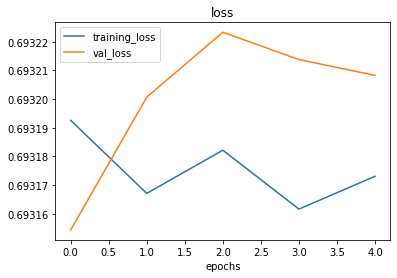

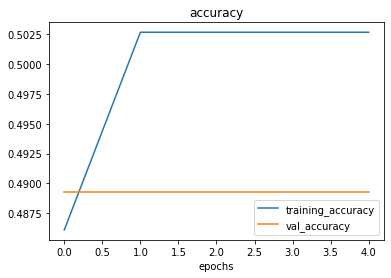

In [49]:
graficar_curva_perdidas(history_1)

### Experimentación
En esta sección se realizarán varios experimentos con tal de poder obtener los mejores parámetros de entrenamiento del modelo creado.

Modelo Experimental # 2

In [50]:
def build_siamese_model_2(input_shape):
  model = tf.keras.Sequential([
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=2,
                                                        activation='relu',
                                                        padding='same',
                                                        input_shape=input_shape),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=2,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.GlobalAveragePooling2D(),
                                tf.keras.layers.Dense(64)
  ])

  return model

In [51]:
IMG_SHAPE = (24, 16, 16)

imgA = tf.keras.Input(IMG_SHAPE)
imgB = tf.keras.Input(IMG_SHAPE)

featureExtractor = build_siamese_model_2(input_shape=IMG_SHAPE)

featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

distancia = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(distancia)

model_2 = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_2 = model_2.fit(
    [pares_entrenamiento[:, 0], pares_entrenamiento[:, 1]], labels_entrenamiento[:],
     validation_data=([pares_prueba[:, 0], pares_prueba[:, 1]], labels_prueba[:]),
     batch_size=32,
     epochs=5
)

Epoch 1/5
128/128 [==============================] - 8s 59ms/step - loss: 0.6932 - accuracy: 0.4849 - val_loss: 0.6931 - val_accuracy: 0.4893
Epoch 2/5
128/128 [==============================] - 7s 57ms/step - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.4893
Epoch 3/5
128/128 [==============================] - 7s 57ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4893
Epoch 4/5
128/128 [==============================] - 7s 57ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4893
Epoch 5/5
128/128 [==============================] - 7s 57ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4893


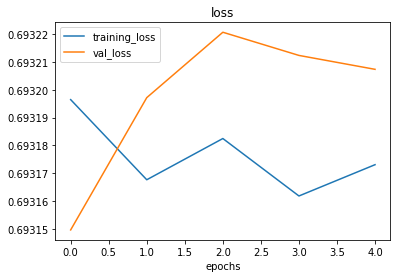

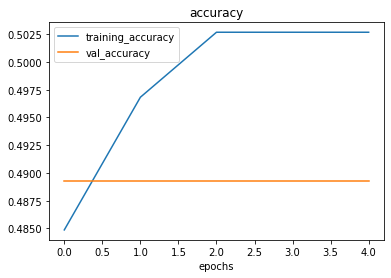

In [52]:
graficar_curva_perdidas(history_2)

Modelo Experimental #3

In [53]:
def build_siamese_model_3(input_shape):
  model = tf.keras.Sequential([
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=2,
                                                        activation='relu',
                                                        padding='same',
                                                        input_shape=input_shape),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=2,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.GlobalAveragePooling2D(),
                                tf.keras.layers.Dense(64)
  ])

  return model

In [54]:
IMG_SHAPE = (24, 16, 16)

imgA = tf.keras.Input(IMG_SHAPE)
imgB = tf.keras.Input(IMG_SHAPE)

featureExtractor = build_siamese_model_3(input_shape=IMG_SHAPE)

featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

distancia = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(distancia)

model_3 = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_3 = model_3.fit(
    [pares_entrenamiento[:, 0], pares_entrenamiento[:, 1]], labels_entrenamiento[:],
     validation_data=([pares_prueba[:, 0], pares_prueba[:, 1]], labels_prueba[:]),
     batch_size=32,
     epochs=5
)

Epoch 1/5
128/128 [==============================] - 9s 65ms/step - loss: 0.6933 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5107
Epoch 2/5
128/128 [==============================] - 8s 62ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6931 - val_accuracy: 0.5107
Epoch 3/5
128/128 [==============================] - 8s 62ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.5107
Epoch 4/5
128/128 [==============================] - 8s 61ms/step - loss: 0.6932 - accuracy: 0.5032 - val_loss: 0.6931 - val_accuracy: 0.5107
Epoch 5/5
128/128 [==============================] - 8s 61ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6931 - val_accuracy: 0.5107


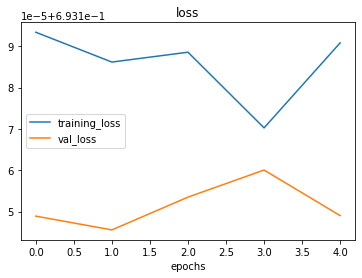

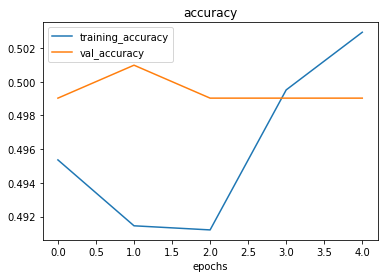

In [99]:
graficar_curva_perdidas(history_3)

Modelo Experimental #4

In [56]:
def build_siamese_model_4(input_shape):
  model = tf.keras.Sequential([
                                tf.keras.layers.Conv2D(filters=128,
                                                        kernel_size=2,
                                                        activation='relu',
                                                        padding='same',
                                                        input_shape=input_shape),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=2,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.GlobalAveragePooling2D(),
                                tf.keras.layers.Dense(64)
  ])

  return model

In [100]:
IMG_SHAPE = (24, 16, 16)

imgA = tf.keras.Input(IMG_SHAPE)
imgB = tf.keras.Input(IMG_SHAPE)

featureExtractor = build_siamese_model_4(input_shape=IMG_SHAPE)

featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

distancia = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(distancia)

model_4 = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_4 = model_4.fit(
    [pares_entrenamiento[:, 0], pares_entrenamiento[:, 1]], labels_entrenamiento[:],
     validation_data=([pares_prueba[:, 0], pares_prueba[:, 1]], labels_prueba[:]),
     batch_size=32,
     epochs=5
)

Epoch 1/5
128/128 [==============================] - 14s 102ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 2/5
128/128 [==============================] - 13s 100ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.4990
Epoch 3/5
128/128 [==============================] - 13s 99ms/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 4/5
128/128 [==============================] - 13s 99ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 5/5
128/128 [==============================] - 13s 99ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.4990


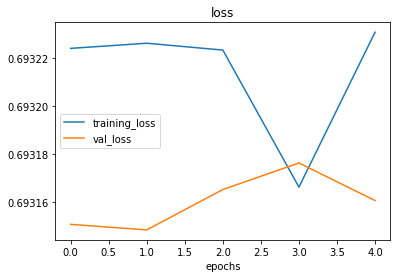

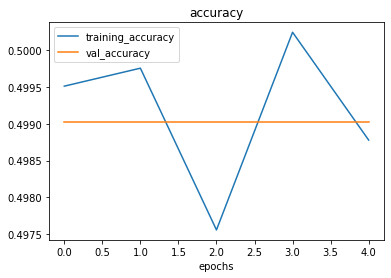

In [101]:
graficar_curva_perdidas(history_4)

Modelo Experimental #5

In [59]:
def build_siamese_model_5(input_shape):
  model = tf.keras.Sequential([
                                tf.keras.layers.Conv2D(filters=128,
                                                        kernel_size=2,
                                                        activation='relu',
                                                        padding='same',
                                                        input_shape=input_shape),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=2,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=2,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.GlobalAveragePooling2D(),
                                tf.keras.layers.Dense(64)
  ])

  return model

In [102]:
IMG_SHAPE = (24, 16, 16)

imgA = tf.keras.Input(IMG_SHAPE)
imgB = tf.keras.Input(IMG_SHAPE)

featureExtractor = build_siamese_model_5(input_shape=IMG_SHAPE)

featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

distancia = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(distancia)

model_5 = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_5 = model_5.fit(
    [pares_entrenamiento[:, 0], pares_entrenamiento[:, 1]], labels_entrenamiento[:],
     validation_data=([pares_prueba[:, 0], pares_prueba[:, 1]], labels_prueba[:]),
     batch_size=32,
     epochs=5
)

Epoch 1/5
128/128 [==============================] - 15s 109ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 2/5
128/128 [==============================] - 14s 107ms/step - loss: 0.6932 - accuracy: 0.4917 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 3/5
128/128 [==============================] - 14s 107ms/step - loss: 0.6933 - accuracy: 0.4939 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 4/5
128/128 [==============================] - 14s 107ms/step - loss: 0.6933 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 5/5
128/128 [==============================] - 14s 106ms/step - loss: 0.6931 - accuracy: 0.5068 - val_loss: 0.6932 - val_accuracy: 0.5010


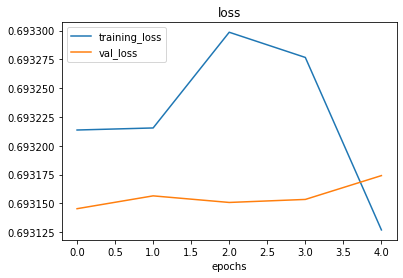

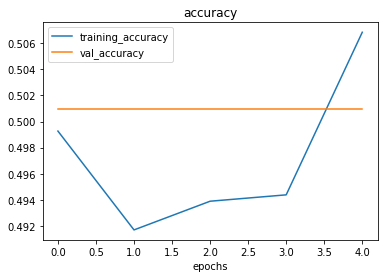

In [103]:
graficar_curva_perdidas(history_5)

Modelo Experimental #6

In [62]:
def build_siamese_model_6(input_shape):
  model = tf.keras.Sequential([
                                tf.keras.layers.Conv2D(filters=128,
                                                        kernel_size=2,
                                                        activation='relu',
                                                        padding='same',
                                                        input_shape=input_shape),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=2,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=2,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.Dropout(0.3),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.GlobalAveragePooling2D(),
                                tf.keras.layers.Dense(128)
  ])

  return model

In [104]:
IMG_SHAPE = (24, 16, 16)

imgA = tf.keras.Input(IMG_SHAPE)
imgB = tf.keras.Input(IMG_SHAPE)

featureExtractor = build_siamese_model_6(input_shape=IMG_SHAPE)

featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

distancia = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(distancia)

model_6 = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_6 = model_6.fit(
    [pares_entrenamiento[:, 0], pares_entrenamiento[:, 1]], labels_entrenamiento[:],
     validation_data=([pares_prueba[:, 0], pares_prueba[:, 1]], labels_prueba[:]),
     batch_size=32,
     epochs=5
)

Epoch 1/5
128/128 [==============================] - 15s 109ms/step - loss: 0.6933 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 2/5
128/128 [==============================] - 14s 106ms/step - loss: 0.6932 - accuracy: 0.4932 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 3/5
128/128 [==============================] - 14s 106ms/step - loss: 0.6933 - accuracy: 0.4939 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 4/5
128/128 [==============================] - 13s 106ms/step - loss: 0.6934 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 5/5
128/128 [==============================] - 14s 106ms/step - loss: 0.6931 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5010


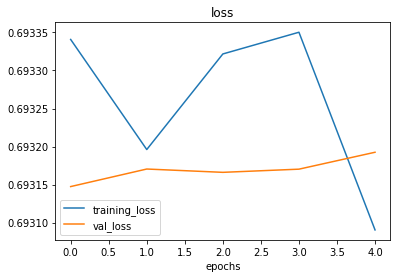

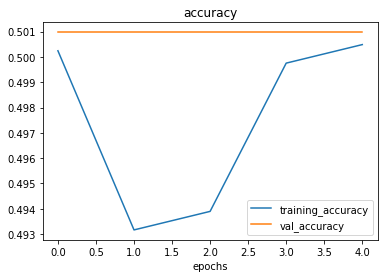

In [105]:
graficar_curva_perdidas(history_6)

Modelo Experimental #7

In [55]:
def build_siamese_model_7(input_shape):
  model = tf.keras.Sequential([
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=10,
                                                        activation='relu',
                                                        padding='same',
                                                        input_shape=input_shape),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=128,
                                                        kernel_size=7,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=128,
                                                        kernel_size=4,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=256,
                                                        kernel_size=4,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(4960)
  ])

  return model

In [56]:
IMG_SHAPE = (24, 16, 16)

imgA = tf.keras.Input(IMG_SHAPE)
imgB = tf.keras.Input(IMG_SHAPE)

featureExtractor = build_siamese_model_7(input_shape=IMG_SHAPE)

featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

distancia = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(distancia)

model_7 = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=['accuracy'])

history_7 = model_7.fit(
    [pares_entrenamiento[:, 0], pares_entrenamiento[:, 1]], labels_entrenamiento[:],
     validation_data=([pares_prueba[:, 0], pares_prueba[:, 1]], labels_prueba[:]),
     batch_size=32,
     epochs=5
)

Epoch 1/5
128/128 [==============================] - 120s 932ms/step - loss: 0.6617 - accuracy: 0.5613 - val_loss: 0.4448 - val_accuracy: 0.7598
Epoch 2/5
128/128 [==============================] - 118s 926ms/step - loss: 0.3184 - accuracy: 0.9026 - val_loss: 0.1989 - val_accuracy: 0.9736
Epoch 3/5
128/128 [==============================] - 118s 921ms/step - loss: 0.1505 - accuracy: 0.9844 - val_loss: 0.1148 - val_accuracy: 0.9883
Epoch 4/5
128/128 [==============================] - 118s 921ms/step - loss: 0.0874 - accuracy: 0.9949 - val_loss: 0.0723 - val_accuracy: 0.9961
Epoch 5/5
128/128 [==============================] - 118s 921ms/step - loss: 0.0513 - accuracy: 0.9990 - val_loss: 0.0411 - val_accuracy: 1.0000


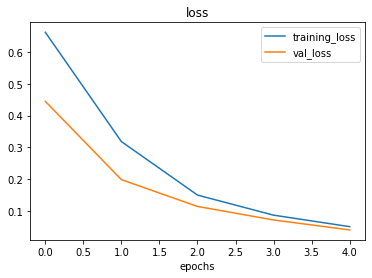

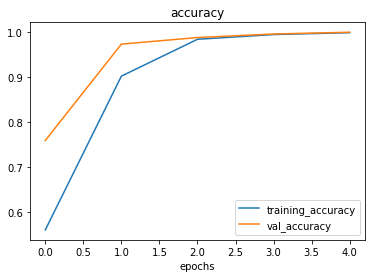

In [57]:
graficar_curva_perdidas(history_7)

### Resultados de Experimentación
Se evaluará con ciertas métricas el rendimiento de la arquitectura de la red neuronal siamesa seleccionada.

In [58]:
model_7.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 24, 16, 16)] 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 24, 16, 16)] 0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 4960)         8914336     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           sequential_3[0][0]         

In [61]:
predicciones = model_7.predict([pares_prueba[:, 0], pares_prueba[:, 1]])

In [62]:
predicciones

array([[0.91554636],
       [0.96435905],
       [0.9283041 ],
       ...,
       [0.00200289],
       [0.97291577],
       [0.00663602]], dtype=float32)

In [70]:
for i in range(len(predicciones)):
  predicciones[i][0] = round(predicciones[i][0])

In [71]:
predicciones

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [74]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel('Label Reales')
    plt.ylabel('Predicciones')

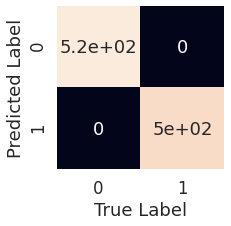

In [73]:
plot_conf_mat(labels_prueba, predicciones)

In [75]:
print(classification_report(labels_prueba, predicciones))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       523
           1       1.00      1.00      1.00       501

    accuracy                           1.00      1024
   macro avg       1.00      1.00      1.00      1024
weighted avg       1.00      1.00      1.00      1024

